In [1]:
import qgrid
qgrid.nbinstall(overwrite=True)
qgrid.set_defaults(remote_js=True, show_toolbar=True)

# BBC Best Films of 21st Century

The BBC has compiled a "best of the century" list of films.  They have also published the top-10 rankings of 177 individual critics that went into building the list.

This notebook experiments with pulling the data into pandas DataFrames and doing some very basic additional analysis of the data.

NOTE: I don't actually feel one way or the other about the list or rankings, and merely wanted some pandas/scikit coding practice.

## Step 1: Data Acquisition

First we need to pull the raw data from the website.  Let's use `requests` to do this.

In [2]:
import requests

r = requests.get('http://www.bbc.com/culture/story/20160819-the-21st-centurys-100-greatest-films-who-voted')
content_str = r.content
# there is an error in the markup, this fixes it
content_str = content_str.replace('<p><strong>Alexander Horwath &ndash; Austrian Film Museum (Austria)</strong><br />', '<p><strong>Alexander Horwath &ndash; Austrian Film Museum (Austria)</strong></p><p>')

Next, we need to parse the `content` and pull out the lists.  We'll use BeautifulSoup for this.

In [3]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(content_str)
# gets the bulk of the content 
ps = soup.find("div", class_="body-content").find_all("p")[1:-3]
# breaks the data into lists of (critic, picks) tuples
critic_picks = [(ps[i], ps[i+1]) for i in range(0,len(ps),2)]

Now we can make some (ugly) functions for pulling out the data from this list data into a tidy DataFrame

In [4]:
def critic_point(critic_val):
    critic_name, critic_details = [i.strip() for i in critic_val.string.split(u'\u2013')]
    critic_nationality = critic_details.split('(')[-1][:-1]
    return {'critic_name': critic_name, 'critic_nationality': critic_nationality}

def proc_movie(movie):
    rank = int(movie.split('.')[0])
    number_removed = '.'.join(movie.split('.')[1:])
    paren_fields = number_removed.strip().split('(')
    movie_title, movie_details = ('('.join(paren_fields[:-1]), paren_fields[-1])
    movie_fields = movie_details.split(' ')
    director, movie_year = (' '.join(movie_fields[:-1])[:-1], movie_fields[-1])
    return {"rank": 11-rank, "title": movie_title, "director": director, "year": int(movie_year[:-1])}

def critic_movies(critic, movies):
    child_elems = [i for i in movies.children]
    for i in range(0,len(child_elems),2):
        movie = proc_movie(child_elems[i])
        movie.update(critic)
        yield movie

def master_list(picks):
    for critic_pick in picks:
        critic_details = critic_point(critic_pick[0])
        for val in critic_movies(critic_details,critic_pick[1]):
            yield val

## Reproducing the BBC List

Using these functions, I'll now build a data frame and try to reproduce the BBC film list.  The way I'll do this is score each movie as eleven points minus the `rank`.  This scoring means that a critic votes 1 point for ranking a movie as 10th best and 10 points for ranking a movie as 1st best. ([Looks like they include a methodology page](http://www.bbc.com/culture/story/20160802-100-greatest-films-of-the-21st-century-infographic))

Below I include not just the top 100, but all the films reported by polled critics.

In [5]:
import pandas as pd

# create the df
df_data = list(master_list(critic_picks))
critic_df = pd.DataFrame(df_data)

# compute the BBC List
bbc_list = (critic_df
            .groupby('title')['rank']
            .sum()
            .sort_values(ascending=False))
qgrid.show_grid(pd.DataFrame(bbc_list))

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Top Ranked Directors By Score

We can just as readily compute scores for directors instead of films.  This gives us a comparable "Best Directors of the 21st Century".

In [8]:
qgrid.show_grid(pd.DataFrame(critic_df
                             .groupby('director')['rank']
                             .sum()
                             .sort_values(ascending=False)))

## Top Ranked Directors By Total Nominated Films

We can also consider ranking directors by the number of films they had nominated.

In [9]:
qgrid.show_grid(pd.DataFrame(critic_df
                             .groupby('director')['title']
                             .nunique()
                             .sort_values(ascending=False)))

## Year Scores

Finally, we can look at the sum of films scores broken down by year.  Looks like 2000, 2001, and 2007 were well above average years for film.

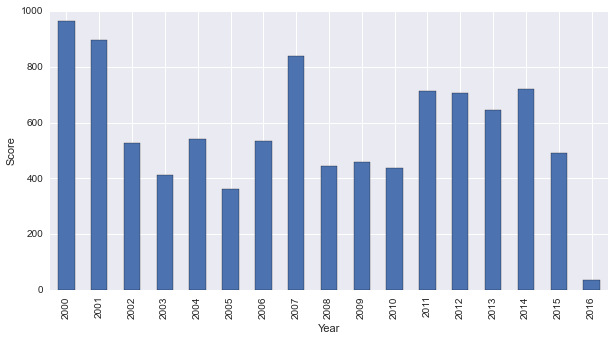

In [10]:
ax = critic_df.groupby('year')['rank'].sum().plot(kind='bar',figsize=(10,5),);
ax.set_xlabel('Year');
ax.set_ylabel('Score');

## Critics clusters

For something a little less "list-y", let's try and see if we can group together similar critics.  

### Critic vectors

To do this grouping, we'll need to be able to measure how similar two critics are to each other based on their rankings.

First, consider a feature space where the dimensions are films.  We can position a critic in this space by positioning a point with dimension values proportional to the scores given each film by that critic.  Let's call this a *critic vector*.



In [11]:
import numpy as np
from scipy.sparse import csr_matrix

# construct a list like [{'criticname':[(movie, rank),...]}, ...]
def cluster_list(picks):
    for critic_pick in picks:
        critic_details = critic_point(critic_pick[0])
        yield (critic_details['critic_name'],
               [(val['title'], val['rank']) 
                for val in critic_movies(critic_details,critic_pick[1])])
# construct empty critic matrix
indptr = [0]
indices = []
data = []
canon = {}
critic_picks_list = list(cluster_list(critic_picks))
for _, movies in critic_picks_list:
    for title, rank in movies:
        index = canon.setdefault(title, len(canon))
        indices.append(index)
        data.append(rank)
    indptr.append(len(indices))
#normalize by 19.62141687 (they are all the same length)
critic_matrix = csr_matrix((data, indices, indptr), dtype=int).toarray()/19.62141687

### Critic similarity

One common way to compute the distance between such sparse vectors is the cosine similarity.  This is essentially just the dot product between the normalized critic vectors.

The matrix storing all the similarities between critics is called the similarity matrix $S$.

In [12]:
S = critic_matrix.dot(critic_matrix.T)
D = np.abs(1.0-S)

### Critic vector clustering

Clustering algorithms recompute the similarity matrix to determine which points constitute a cluster.  Below I'm going to use a kind of clustering called Agglomerative Clustering.

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(critic_matrix, 'average', metric='cosine')

### Critic Cluster Tree

Agglomerative clustering produces a cluster tree, a heirarchical taxonomy of similar data points.  This tree can be drawn as a dendrogram.  The dendrogram is colored by subtrees that are similar enough to be called clusters.  Those branches that are the default blue are outliers.

The way this dendrogram is drawn is that the farther to the left a branching point is located, then the more disimilar the leaves of the branches.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


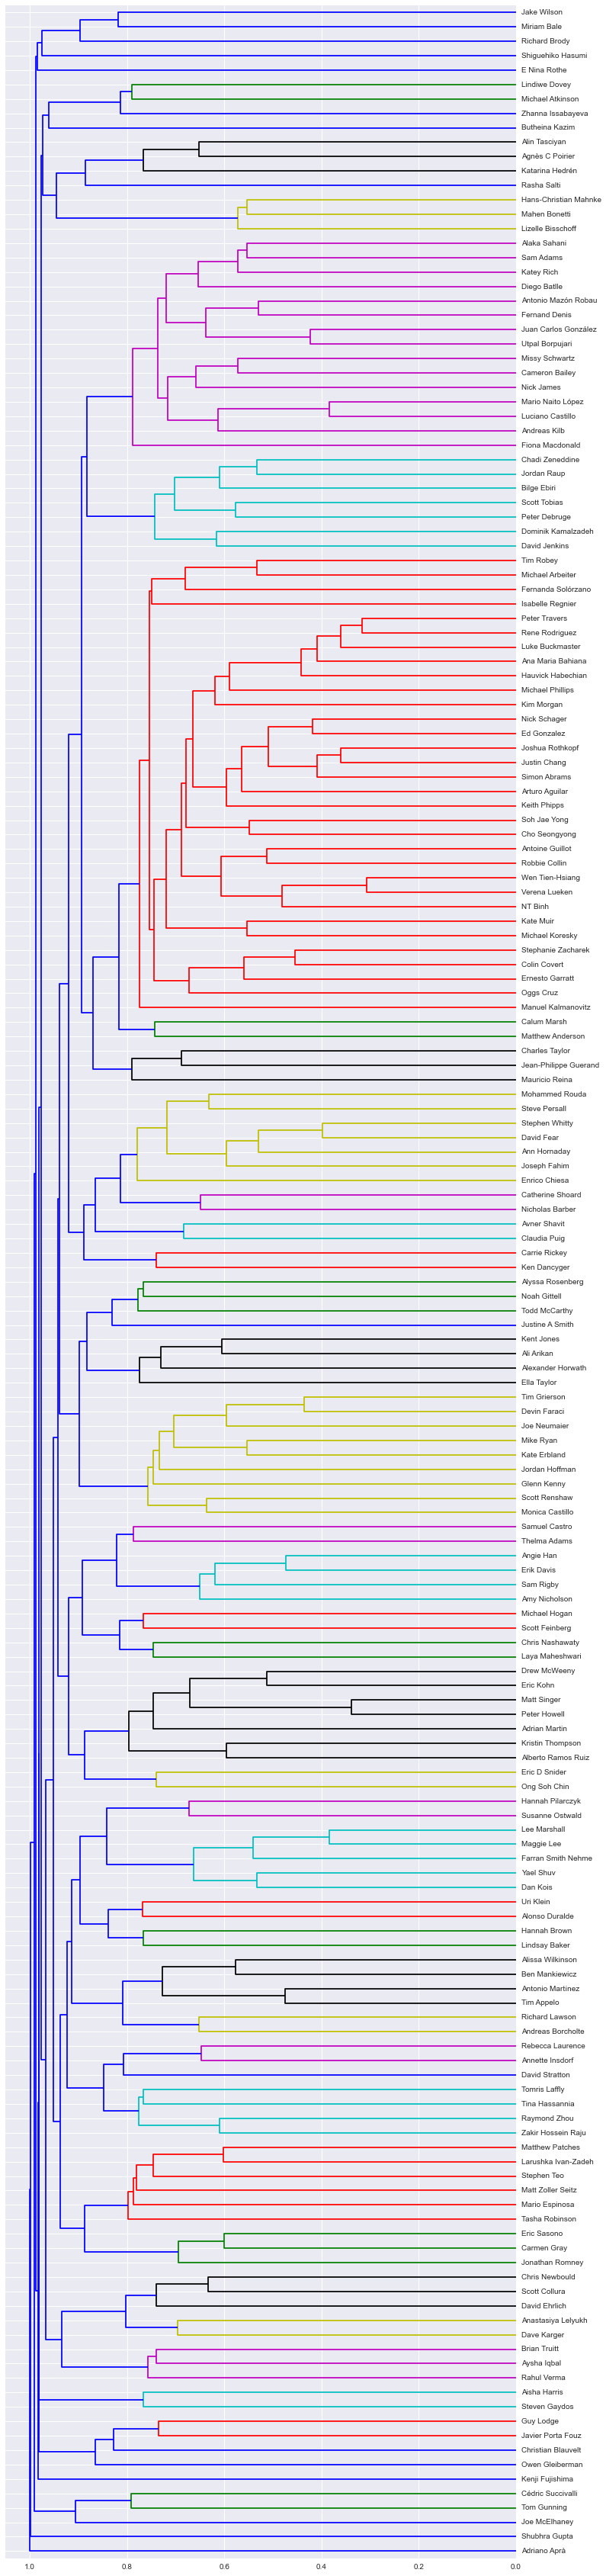

In [14]:
plt.figure(figsize=(12,60))
dendrogram(Z, 
           color_threshold=0.8*max(Z[:,2]), 
           labels=[i[0] for i in critic_picks_list], 
           orientation="right",
           leaf_font_size=28.);